## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm lxml

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import XML support
import xml.etree.ElementTree as ET

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'cvat-instance-segmentation-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/cvat-instance-segmentation-toy-dataset
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/cvat-instance-segmentation-toy-dataset.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/cvat-instance-segmentation-toy-dataset/resolve/main/cvat-instance-segmentation-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [6]:
 # Assuming the images are stored in a subfolder named 'default'
img_dir = dataset_path/'images/default'

# Assuming annotation file is in XML format and located in any subdirectory of the dataset
annotation_file_path = dataset_path/'annotations.xml'

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default
Annotation File,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/annotations.xml


### Get Keypoint Annotations

#### Define a function to parse the CVAT XML annotations

In [7]:
def parse_cvat_segmentation_xml(xml_content):
    """
    Parses an XML string representing image segmentation data from CVAT and converts it into a pandas DataFrame.

    The function expects an XML string with a structure containing 'image' elements, each with 'id', 'name', 'width', 
    and 'height' attributes, and nested 'polygon' elements with 'label' and 'points' attributes. It processes this 
    XML content to extract relevant data and organizes it into a structured DataFrame.

    Parameters:
    xml_content (str): A string containing the XML data to be parsed.

    Returns:
    pandas.DataFrame: A DataFrame where each row represents an image and contains the following columns:
                      'Image ID', 'Image Name', 'Width', 'Height', and 'Polygons'.
                      'Polygons' is a list of dictionaries, each representing a polygon with 'Label' and 'Points'.
    """

    # Parse the XML content from the provided string.
    root = ET.fromstring(xml_content)
    data = {}

    for image in root.findall('image'):
        # Extract attributes for each image.
        image_id = image.get('id')
        image_name = image.get('name')
        width = image.get('width')
        height = image.get('height')

        # Initialize a dictionary to store image data.
        image_data = {
            'Image ID': int(image_id),
            'Image Name': image_name,
            'Width': int(width),
            'Height': int(height),
            'Polygons': []
        }

        # Iterate over each polygon element within the current image.
        for polygon in image.findall('polygon'):
            # Extract the label and points of the polygon.
            label = polygon.get('label')
            points = polygon.get('points').split(';')
            # Convert the points string into a list of (x, y) tuples.
            points = [tuple([float(c) for c in xy.split(',')]) for xy in points]

            # Create a dictionary to store the polygon data.
            points_data = {
                'Label': label,
                'Points': points
            }
            image_data['Polygons'].append(points_data)

        # Add the processed image data to the main data dictionary.
        data[image_id] = image_data

    # Convert the data dictionary into a pandas DataFrame and return it.
    return pd.DataFrame.from_dict(data, orient='index')

#### Load CVAT XML annotations into a DataFrame

In [8]:
# Read the XML file
with open(annotation_file_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

# Parse the XML content
annotation_df = parse_cvat_segmentation_xml(xml_content)

# Add a new column 'Image ID' by extracting it from 'Image Name'
# This assumes that the 'Image ID' is the part of the 'Image Name' before the first period
annotation_df['Image ID'] = annotation_df['Image Name'].apply(lambda x: x.split('.')[0])

# Set the new 'Image ID' column as the index of the DataFrame
annotation_df = annotation_df.set_index('Image ID')

# Display the first few rows of the DataFrame
annotation_df.head()

,Image Name,Width,Height,Polygons
Image ID,,,,
258421,258421.jpg,768,1152,"[{'Label': 'person', 'Points': [(377.0, 775.5), (368.0, 774.5), (346.5, 764.0), (349.5, 751.0), (348.5, 707.0), (358.5, 668.0), (343.5, 651.0), (359.5, 605.0), (379.5, 583.0), (366.01, 583.39), (362.55, 575.78), (361.85, 565.4), (353.2, 557.09), (357.7, 547.4), (350.78, 532.53), (356.32, 520.76), (359.78, 481.31), (376.39, 467.47), (387.46, 469.55), (401.3, 484.08), (405.8, 501.04), (394.03, 505.88), (394.73, 519.03), (399.92, 531.14), (374.66, 554.33), (369.81, 571.28), (374.31, 574.05), (388.15, 574.39), (397.49, 569.9), (402.5, 578.0), (410.5, 594.0), (412.5, 668.0), (387.0, 667.5), (375.5, 692.0), (376.5, 738.0), (380.5, 753.0), (388.5, 764.0), (386.5, 772.0)]}, {'Label': 'person', 'Points': [(404.0, 775.5), (396.5, 766.0), (411.5, 753.0), (411.5, 738.0), (416.5, 731.0), (412.5, 598.0), (419.5, 559.0), (416.0, 554.5), (404.0, 566.5), (387.0, 572.5), (375.5, 566.0), (377.5, 554.0), (405.5, 529.0), (413.5, 504.0), (414.5, 493.0), (386.5, 463.0), (388.5, 453.0), (399.0, 443.5), (413.0, 444.5), (423.5, 453.0), (457.5, 506.0), (452.5, 575.0), (458.5, 607.0), (447.5, 635.0), (444.5, 676.0), (452.5, 764.0), (443.0, 770.5)]}]"
3075367,3075367.jpg,1344,768,"[{'Label': 'person', 'Points': [(829.0, 466.5), (825.5, 464.0), (824.5, 455.0), (825.5, 425.0), (828.0, 419.5), (833.5, 418.0), (827.5, 417.0), (822.5, 396.0), (825.5, 327.0), (843.5, 313.0), (842.5, 296.0), (833.5, 291.0), (832.5, 270.0), (837.0, 265.5), (856.0, 264.5), (868.5, 277.0), (870.5, 306.0), (881.5, 318.0), (883.5, 329.0), (893.0, 332.5), (899.5, 340.0), (901.5, 367.0), (883.5, 382.0), (849.5, 443.0), (842.5, 448.0), (838.5, 460.0)]}, {'Label': 'person', 'Points': [(714.0, 766.5), (664.0, 765.5), (654.0, 716.5), (640.0, 765.5), (578.5, 764.0), (578.5, 599.0), (570.5, 587.0), (592.5, 403.0), (583.5, 339.0), (525.5, 278.0), (463.5, 187.0), (423.5, 98.0), (422.5, 72.0), (444.0, 52.5), (460.5, 62.0), (458.5, 104.0), (485.5, 166.0), (581.0, 270.5), (623.0, 295.5), (644.5, 293.0), (630.5, 261.0), (642.5, 193.0), (667.0, 182.5), (707.0, 191.5), (719.5, 249.0), (709.0, 307.5), (774.0, 271.5), (848.5, 176.0), (875.5, 108.0), (867.5, 55.0), (902.0, 63.5), (908.5, 76.0), (902.5, 134.0), (858.5, 233.0), (759.5, 350.0), (736.5, 495.0), (752.5, 614.0)]}, {'Label': 'person', 'Points': [(359.0, 509.5), (355.0, 509.5), (350.5, 502.0), (353.5, 486.0), (349.5, 475.0), (349.5, 449.0), (345.5, 430.0), (339.5, 419.0), (337.5, 394.0), (327.5, 378.0), (331.5, 371.0), (332.5, 357.0), (342.5, 345.0), (345.5, 327.0), (354.0, 313.5), (365.5, 317.0), (366.5, 339.0), (385.0, 350.5), (399.5, 371.0), (398.5, 383.0), (390.0, 391.5), (390.5, 378.0), (383.0, 369.5), (379.5, 370.0), (380.5, 441.0), (376.5, 471.0), (370.0, 464.5), (364.5, 472.0), (362.5, 482.0), (364.5, 504.0)]}, {'Label': 'car', 'Points': [(1343.0, 764.5), (964.0, 745.5), (930.0, 764.5), (914.5, 759.0), (904.0, 722.5), (865.0, 706.5), (848.0, 735.5), (801.0, 735.5), (788.5, 699.0), (792.5, 577.0), (821.5, 476.0), (849.5, 454.0), (890.5, 382.0), (930.0, 355.5), (1021.0, 347.5), (1195.0, 358.5), (1287.0, 378.5), (1343.0, 436.0)]}]"
3076319,3076319.jpg,768,1120,"[{'Label': 'person', 'Points': [(590.0, 1119.0), (508.5, 1119.0), (393.5, 881.0), (363.5, 778.0), (359.5, 738.0), (377.5, 685.0), (420.5, 660.0), (388.5, 650.0), (410.5, 606.0), (412.5, 477.0), (349.5, 383.0), (364.5, 338.0), (341.5, 303.0), (369.5, 313.0), (396.5, 191.0), (449.0, 157.5), (496.0, 169.5), (524.5, 203.0), (534.5, 320.0), (577.5, 380.0), (588.5, 493.0), (635.5, 554.0), (631.5, 567.0), (687.5, 625.0), (704.5, 673.0), (698.5, 743.0), (632.5, 833.0), (618.5, 955.0), (573.5, 1096.0)]}, {'Label': 'person', 'Points': [(262.0, 1119.0), (128.5, 1119.0), (131.5, 1089.0), (35.5, 901.0), (11.5, 772.0), (33.5, 686.0), (70.5, 663.0), (34.5, 612.0), (25.5, 569.0), (52.5, 375.0), (97.0, 332.5), (195.5, 306.0), (205.5, 255.0), (192.5, 220.0), (240.0, 154.5), (290.0, 133.5), (323.5, 153.0), (341.5, 209.0), (332

### Get Image File Paths

In [9]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem.split('.')[0] : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in each image folder
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 31


,0
adults-affection-attractive-2760688,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default/adults-affection-attractive-2760688.jpg
258421,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default/258421.jpg
3075367,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default/3075367.jpg
3076319,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default/3076319.jpg
3145551,/mnt/980_1TB_2/Datasets/cvat-instance-segmentation-toy-dataset/images/default/3145551.jpg


In [10]:
annotation_df.iloc[0].to_frame()

,258421
Image Name,258421.jpg
Width,768
Height,1152
Polygons,"[{'Label': 'person', 'Points': [(377.0, 775.5), (368.0, 774.5), (346.5, 764.0), (349.5, 751.0), (348.5, 707.0), (358.5, 668.0), (343.5, 651.0), (359.5, 605.0), (379.5, 583.0), (366.01, 583.39), (362.55, 575.78), (361.85, 565.4), (353.2, 557.09), (357.7, 547.4), (350.78, 532.53), (356.32, 520.76), (359.78, 481.31), (376.39, 467.47), (387.46, 469.55), (401.3, 484.08), (405.8, 501.04), (394.03, 505.88), (394.73, 519.03), (399.92, 531.14), (374.66, 554.33), (369.81, 571.28), (374.31, 574.05), (388.15, 574.39), (397.49, 569.9), (402.5, 578.0), (410.5, 594.0), (412.5, 668.0), (387.0, 667.5), (375.5, 692.0), (376.5, 738.0), (380.5, 753.0), (388.5, 764.0), (386.5, 772.0)]}, {'Label': 'person', 'Points': [(404.0, 775.5), (396.5, 766.0), (411.5, 753.0), (411.5, 738.0), (416.5, 731.0), (412.5, 598.0), (419.5, 559.0), (416.0, 554.5), (404.0, 566.5), (387.0, 572.5), (375.5, 566.0), (377.5, 554.0), (405.5, 529.0), (413.5, 504.0), (414.5, 493.0), (386.5, 463.0), (388.5, 453.0), (399.0, 443.5), (413.0, 444.5), (423.5, 453.0), (457.5, 506.0), (452.5, 575.0), (458.5, 607.0), (447.5, 635.0), (444.5, 676.0), (452.5, 764.0), (443.0, 770.5)]}]"


#### Get image classes

In [11]:
# Explode the 'boxes_df' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'boxes_df' column to 'boxes_df'
# Apply the pandas Series function to the 'boxes_df' column of the dataframe
polygon_df = annotation_df['Polygons'].explode().to_frame().Polygons.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = polygon_df['Label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,person
1,car


### Visualizing Keypoint Annotations

#### Generate a color map

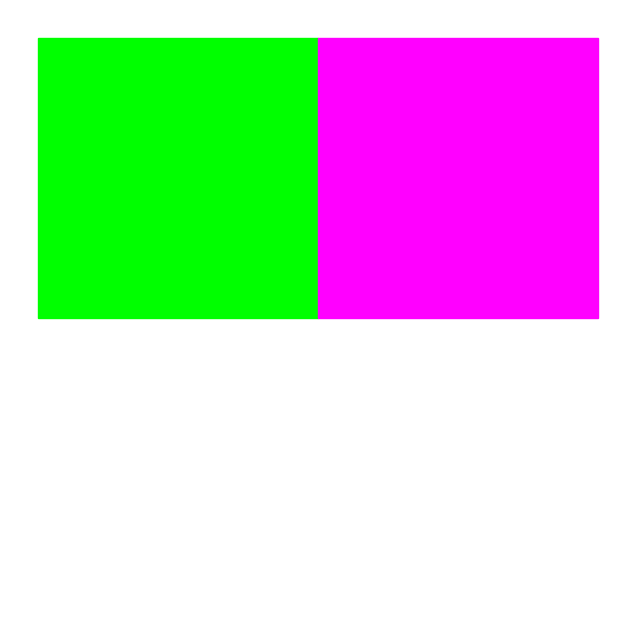

In [12]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [13]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [14]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (768, 1152)


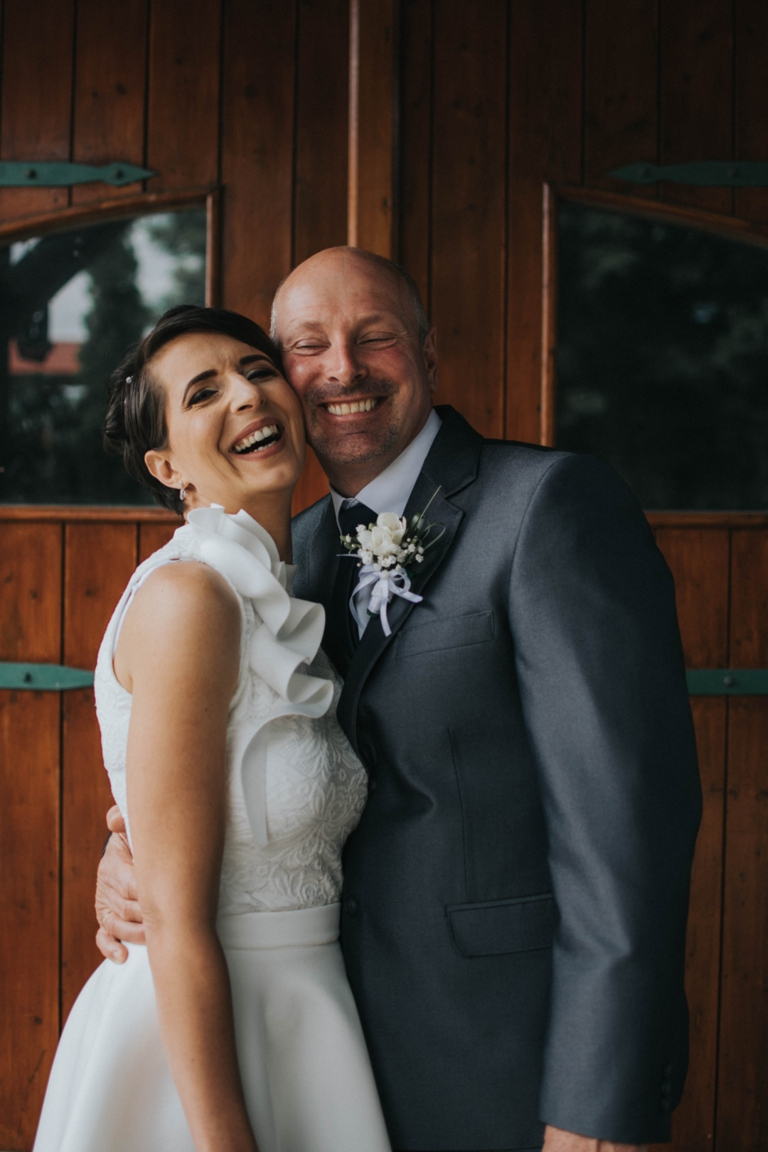

In [15]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [16]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,adults-affection-attractive-2760688
Image Name,adults-affection-attractive-2760688.jpg
Width,768
Height,1152
Polygons,"[{'Label': 'person', 'Points': [(389.0, 1151.0), (34.5, 1151.0), (82.5, 992.0), (103.0, 965.5), (147.5, 953.0), (135.5, 848.0), (104.5, 763.0), (97.5, 672.0), (129.5, 581.0), (186.5, 519.0), (127.5, 466.0), (106.5, 422.0), (118.5, 369.0), (181.0, 306.5), (258.0, 325.5), (301.5, 412.0), (285.5, 566.0), (291.5, 594.0), (323.5, 610.0), (335.5, 714.0), (366.5, 777.0), (341.5, 848.0), (337.5, 944.0)]}, {'Label': 'person', 'Points': [(532.0, 1151.0), (397.5, 1151.0), (345.5, 958.0), (345.5, 855.0), (369.5, 776.0), (340.5, 720.0), (344.5, 678.0), (325.5, 647.0), (326.5, 608.0), (296.5, 592.0), (294.5, 540.0), (298.0, 519.5), (341.5, 493.0), (273.5, 329.0), (284.5, 283.0), (332.0, 249.5), (385.0, 260.5), (411.5, 287.0), (431.5, 338.0), (434.0, 411.5), (449.0, 407.5), (486.0, 440.5), (601.0, 461.5), (671.5, 580.0), (698.5, 786.0), (681.5, 1090.0), (663.0, 1137.5), (549.0, 1127.5)]}]"


#### Define a function to convert segmentation polygons to images

In [17]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

#### Annotate sample image

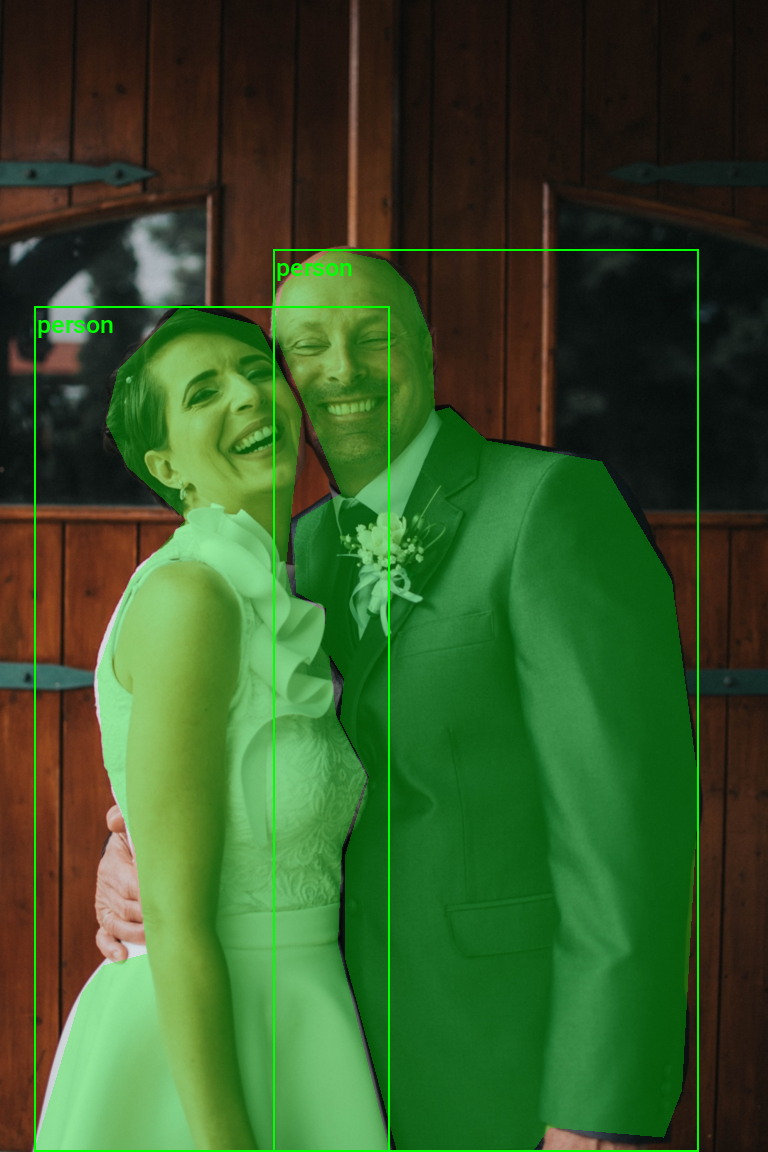

In [18]:
# Extract the polygon points for segmentation mask
polygon_points = annotation_df.loc[file_id]['Polygons']

# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, polygon['Points']) for polygon in polygon_points]

# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

# Extract the labels and bounding box annotations for the sample image
labels = [polygon['Label'] for polygon in annotation_df.loc[file_id]['Polygons']]
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes,
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [19]:
# Set training image size
train_sz = 384

#### Initialize custom transforms

In [20]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

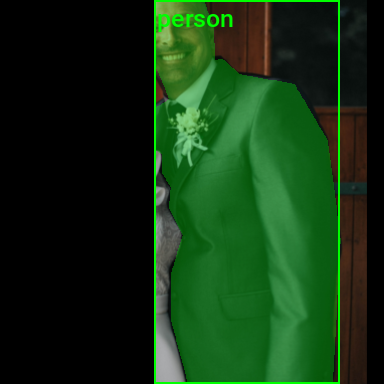

Source Image:,"(768, 1152)"
Cropped Image:,"(443, 803)"
Resized Image:,"(211, 382)"
Padded Image:,"(382, 382)"
Resized Padded Image:,"(384, 384)"


In [21]:
# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': BoundingBoxes(data=bboxes, format='xyxy', canvas_size=sample_img.size[::-1]), 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [22]:
class CVATInstSegDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding bounding box annotations and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the CVATInstSegDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]
        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]
        # Load the image and its target (bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')

        # Extract the polygon points for segmentation mask
        polygon_points = annotation['Polygons']
        # Generate mask images from polygons
        mask_imgs = [create_polygon_mask(image.size, polygon['Points']) for polygon in polygon_points]
        # Convert mask images to tensors
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        
        # Generate bounding box annotations from segmentation masks
        bbox_tensor = torchvision.ops.masks_to_boxes(masks)
        # Create a BoundingBoxes object with the bounding boxes
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        
        # Convert the class labels to indices
        annotation_labels = [box['Label'] for box in annotation['Polygons']]
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])
        
        return image, {'masks': masks,'boxes': boxes, 'labels': labels}

### Image Transforms

In [23]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [24]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = CVATInstSegDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,31


### Inspect Samples

**Inspect training set sample**

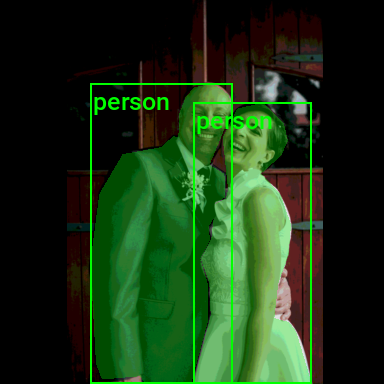

In [25]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)